# Fully Convolution Neural Networks for Image Segmentation

### Imports

In [49]:
import os
import zipfile
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import list_show_annotation_torch

from torchvision.models import vgg16, VGG16_Weights

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

### Download the Dataset

In [1]:
# download the dataset (zipped file)
!wget https://storage.googleapis.com/learning-datasets/fcnn-dataset.zip  -O /tmp/fcnn-dataset.zip

--2025-03-14 14:43:57--  https://storage.googleapis.com/learning-datasets/fcnn-dataset.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.179.123, 142.250.178.155, 142.250.201.187, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.179.123|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 125577577 (120M) [application/zip]
Saving to: ‘/tmp/fcnn-dataset.zip’

/tmp/fcnn-dataset.z 100%[===================>] 119,76M  11,3MB/s    in 16s     

2025-03-14 14:44:14 (7,37 MB/s) - ‘/tmp/fcnn-dataset.zip’ saved [125577577/125577577]



In [4]:
# extract the downloaded dataset to a local directory: /tmp/fcnn
local_zip = "/tmp/fcnn-dataset.zip"
with zipfile.ZipFile(local_zip, "r") as zip_ref:
    zip_ref.extractall("/tmp/fcnn")

The images contain the video frames

The annotations contain pixel-wise label maps
- each label map has the shape (height, width, 1) with each point in this space denoting the corresponding pixel's class.
- classes are in range [0, 11] (12 classes) and the pixel labels correspond to these classes

In [2]:
# pixel labels in the video frames
class_names = [
    "sky",
    "building",
    "column/pole",
    "road",
    "side walk",
    "vegetation",
    "traffic light",
    "fence",
    "vehicle",
    "pedestrian",
    "byciclist",
    "void",
]

In [19]:
pd.DataFrame(class_names, columns=["Class Name"])

,Class Name
0,sky
1,building
2,column/pole
3,road
4,side walk
5,vegetation
6,traffic light
7,fence
8,vehicle
9,pedestrian


### Load and Prepare the Dataset
- resize the height and width of the input images and label maps (224 x 224px by default)
- normalize the input images' pixel values to fall in range `[-1, 1]`
- reshape the label maps from `(height, width, 1)` to `(height, width, 12)` with each slice along the third axis having `1` if it belongs to the class corresponding to that slice's index else `0`.
	- for example, if a pixel is part of a road, then using the table above, that point at slice #3 will be labeled as `1` and it will be `0` in all other slices.
	```python
	# if we have a label map with 3 classes
	n_classes = 3
	# this is the original annotation
	orgi_anno = [0 1 2]
	# reshaped annotation will have 3 slices and its content will look like this
	reshaped_anno = [1 0 0][0 1 0][0 0 1]
	```

In [4]:
# show directories downloaded
!ls /tmp/fcnn/dataset1/

annotations_prepped_test   images_prepped_test
annotations_prepped_train  images_prepped_train


In [5]:
BATCH_SIZE = 64

class SegmentationDatset(Dataset):
    def __init__(self, image_paths, label_map_paths, class_names, height=224, width=224):
        self.image_paths = image_paths
        self.label_map_paths = label_map_paths
        self.height = height
        self.width = width
        self.class_names = class_names

        self.image_tranform = transforms.Compose([
            transforms.Resize((height, width)),
            transforms.ToTensor(), # [0, 1]
            transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                std=[0.5, 0.5, 0.5]) # [-1, 1]
        ])

        self.mask_transform = transforms.Resize((height, width), interpolation=Image.NEAREST)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        # load image
        image = Image.open(self.image_paths[index]).convert("RGB")
        image = self.image_tranform(image)

        # load mask
        mask = Image.open(self.label_map_paths[index]).convert("L")
        mask = self.mask_transform(mask)
        mask = torch.from_numpy(np.array(mask)).long()

        # one-hot encode mask
        mask_one_hot = torch.zeros((len(self.class_names), self.height, self.width), dtype=torch.int32)
        for c in range(len(self.class_names)):
            mask_one_hot[c] = (mask == c)

        return image, mask_one_hot

In [6]:
BATCH_SIZE = 64

def get_dataset_slice_paths(image_dir, label_map_dir):
    """
    Generate the list of image and label map paths

    Args:
        image_dir (str): path to the input image directory
        label_map_dir (str): path to the label map directory

    Returns:
        image_paths (List[str]): paths to each image file
        label_map_paths (List[str]): paths to each label map file
    """

    image_file_lst = os.listdir(image_dir)
    label_map_file_lst = os.listdir(label_map_dir)

    image_paths = [os.path.join(image_dir, fname) for fname in image_file_lst]
    label_map_paths = [os.path.join(label_map_dir, fname) for fname in label_map_file_lst]

    return image_paths, label_map_paths

In [7]:
def get_dataloader(
    image_paths, label_map_paths, class_names, batch_size=64, shuffle=True, height=224, width=224
):
    dataset = SegmentationDatset(image_paths, label_map_paths, class_names, height, width)
    dataloader = DataLoader(dataset, batch_size, shuffle)
    return dataloader

In [8]:
# get the paths to the images
training_image_paths, training_label_map_paths = get_dataset_slice_paths(
    "/tmp/fcnn/dataset1/images_prepped_train/", "/tmp/fcnn/dataset1/annotations_prepped_train/"
)
validation_image_paths, validation_label_map_paths = get_dataset_slice_paths(
    "/tmp/fcnn/dataset1/images_prepped_test/", "/tmp/fcnn/dataset1/annotations_prepped_test/"
)

# generate the train and val sets
train_loader = get_dataloader(
    training_image_paths, training_label_map_paths, class_names, batch_size=BATCH_SIZE, shuffle=True
)
val_loader = get_dataloader(
    validation_image_paths,
    validation_label_map_paths,
    class_names,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

### Visualize Dataset

In [9]:
# generate a list that contains one color for each class
colors = sns.color_palette(None, len(class_names))

# print class name - normalized RGB tuple pairs
# the tuple values will be multiplied by 255 in the helper functions later
# to convert to the (0,0,0) to (255,255,255) RGB values you might be familiar with
for class_name, color in zip(class_names, colors):
    print(f"{class_name} -- {color}")

sky -- (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
building -- (1.0, 0.4980392156862745, 0.054901960784313725)
column/pole -- (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
road -- (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
side walk -- (0.5803921568627451, 0.403921568627451, 0.7411764705882353)
vegetation -- (0.5490196078431373, 0.33725490196078434, 0.29411764705882354)
traffic light -- (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)
fence -- (0.4980392156862745, 0.4980392156862745, 0.4980392156862745)
vehicle -- (0.7372549019607844, 0.7411764705882353, 0.13333333333333333)
pedestrian -- (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)
byciclist -- (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
void -- (1.0, 0.4980392156862745, 0.054901960784313725)


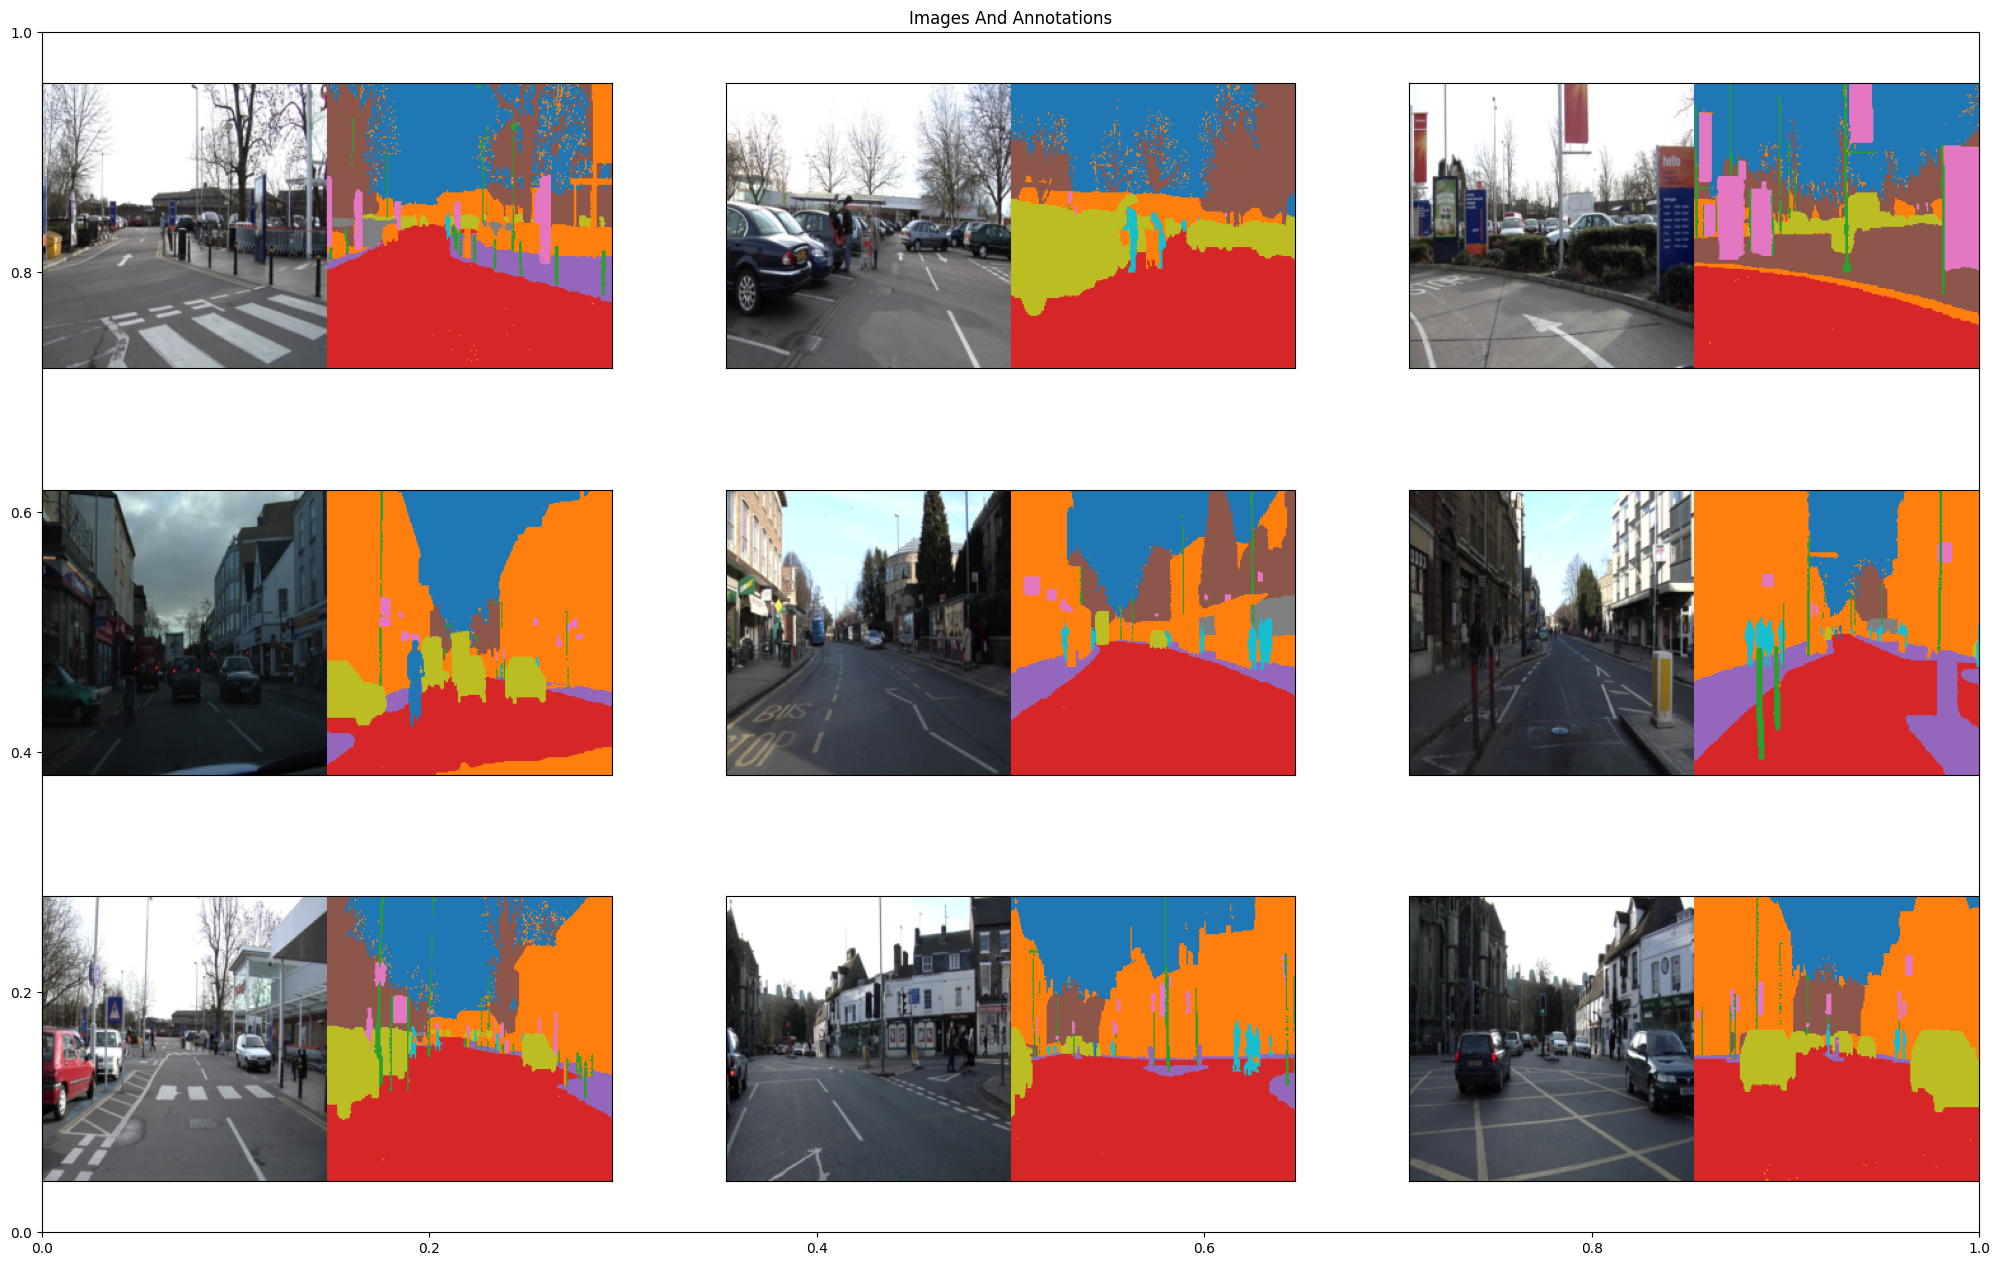

In [10]:
list_show_annotation_torch(train_loader)

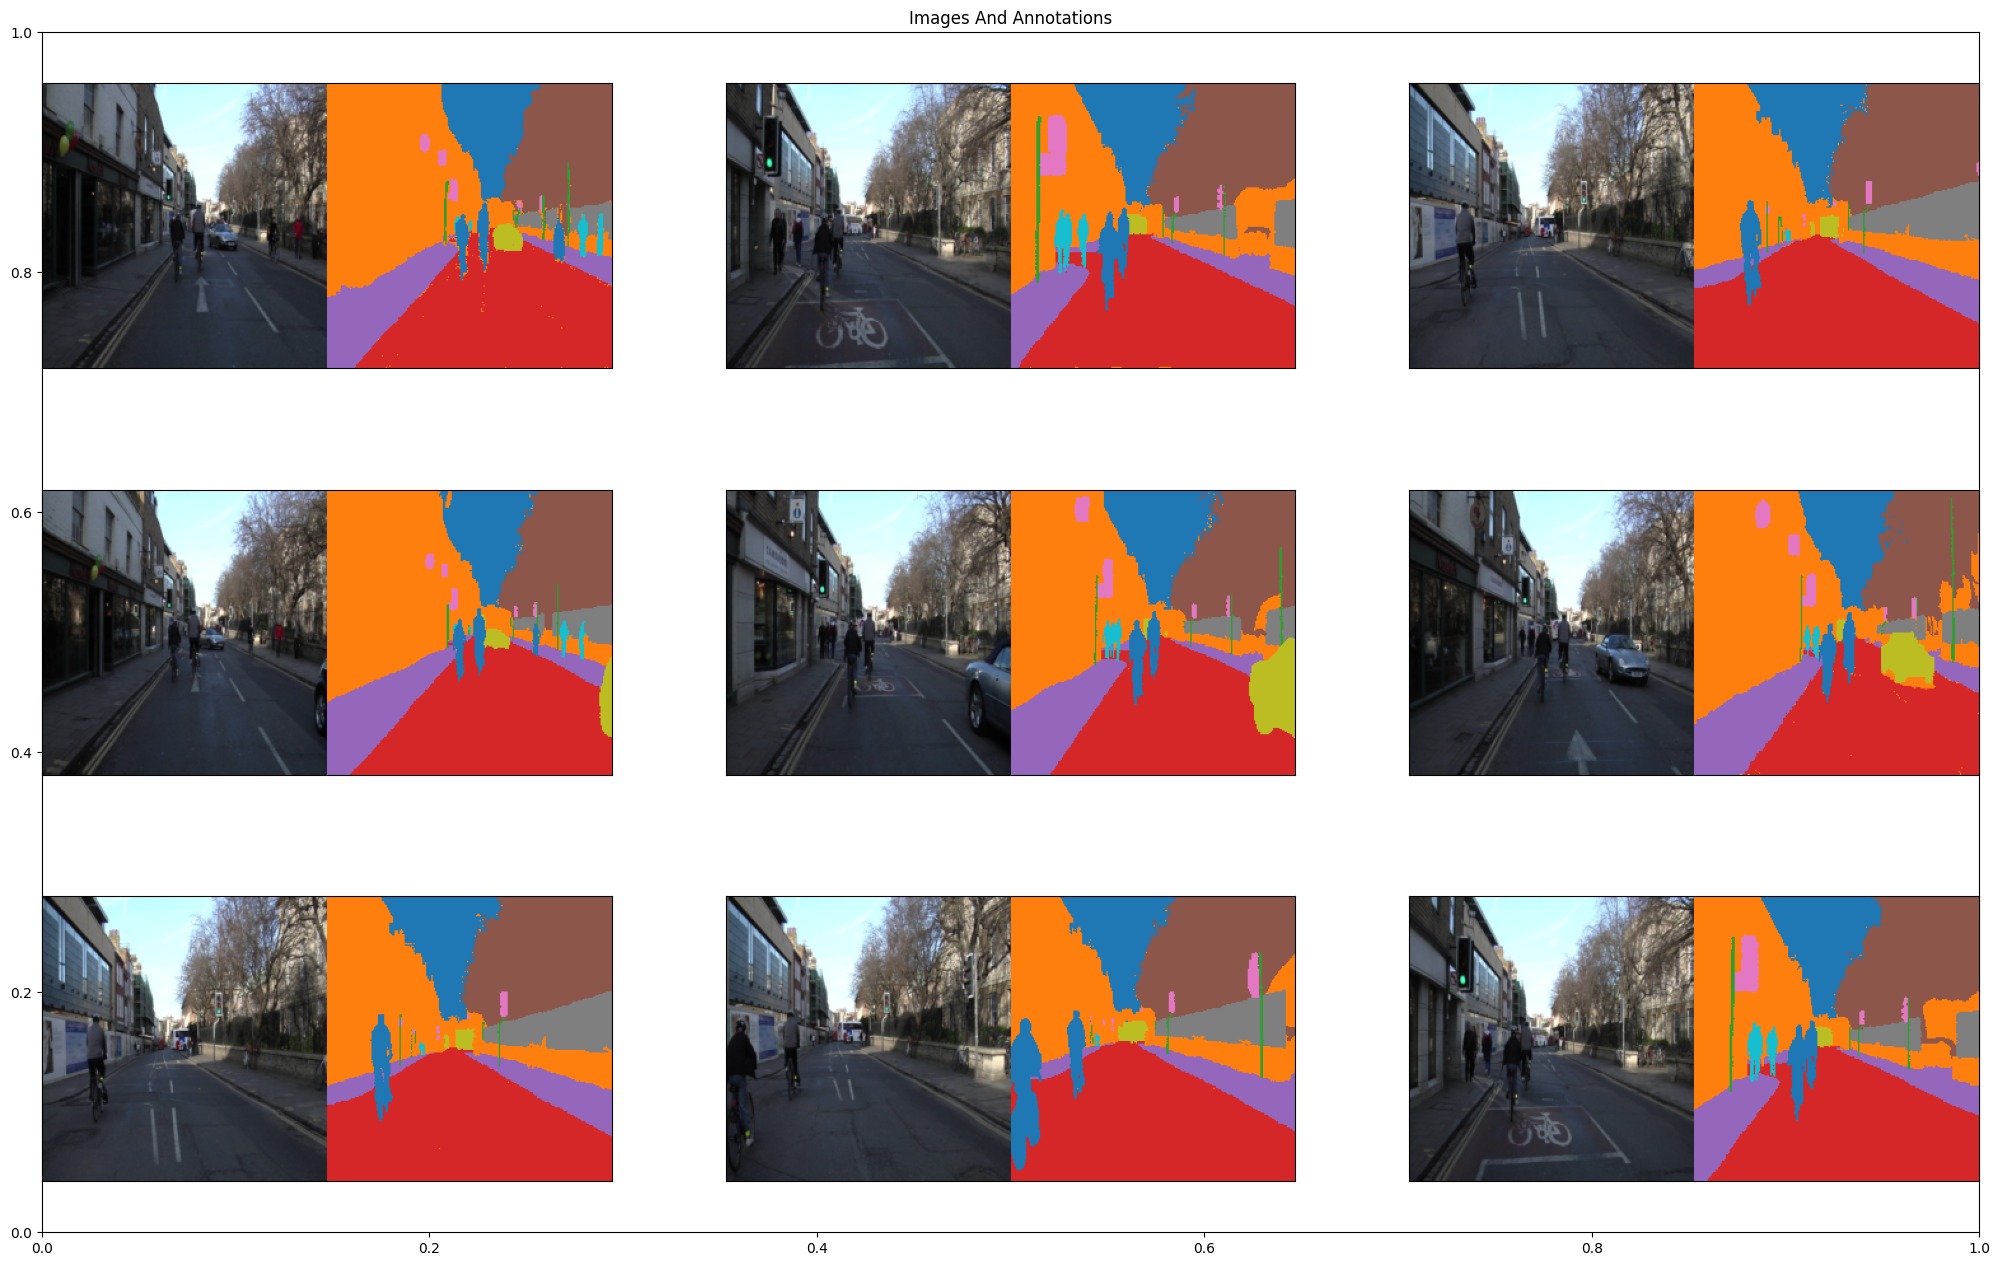

In [11]:
list_show_annotation_torch(val_loader)

### Define the Model

#### Pooling Block of VGG

In [42]:
class VGGBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        n_convs,
        kernel_size=3,
        activation=nn.ReLU,
        pool_size=2,
        pool_stride=2,
    ):
        super().__init__()

        layers = []

        for i in range(n_convs):
            layers.append(nn.Conv2d(
                in_channels=in_channels if i == 0 else out_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                padding=kernel_size // 2,  # same padding
            ))
            layers.append(activation(inplace=True))

        self.conv_layers = nn.Sequential(*layers)
        self.pool = nn.MaxPool2d(kernel_size=pool_size, stride=pool_stride)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.pool(x)

        return x

#### VGG-16 Encoder

In [50]:
class VGGEncoder(nn.Module):
    def __init__(self, input_channels=3, pretrained=True):
        super().__init__()

        self.block1 = VGGBlock(input_channels, 64, n_convs=2)
        self.block2 = VGGBlock(64, 128, n_convs=2)
        self.block3 = VGGBlock(128, 256, n_convs=3)
        self.block4 = VGGBlock(256, 512, n_convs=3)
        self.block5 = VGGBlock(512, 512, n_convs=3)

        self.conv6 = nn.Conv2d(512, 4096, kernel_size=7, padding=3)  # same padding
        self.relu6 = nn.ReLU(inplace=True)

        self.conv7 = nn.Conv2d(4096, 4096, kernel_size=1)  # 1x1 conv
        self.relu7 = nn.ReLU(inplace=True)

        if pretrained:
            self._load_pretrained_weights()

    def forward(self, x):
        p1 = self.block1(x)  # (B,64,H/2,W/2)
        p2 = self.block2(p1)  # (B,128,H/4,W/4)
        p3 = self.block3(p2)  # (B,256,H/8,W/8)
        p4 = self.block4(p3)  # (B,512,H/16,W/16)
        p5 = self.block5(p4)  # (B,512,H/32,W/32)

        c6 = self.relu6(self.conv6(p5))  # (B,4096,H/32,W/32)
        c7 = self.relu7(self.conv7(c6))  # (B,4096,H/32,W/32)

        return p1, p2, p3, p4, c7

    def _load_pretrained_weights(self):
        vgg = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
        pretrained_dict = vgg.features.state_dict()

        model_dict = self.state_dict()

        # filter out unnecessary keys
        pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
        model_dict.update(pretrained_dict)
        self.load_state_dict(model_dict, strict=False)
        print("Pretrained VGG16 weights loaded successfully.")

#### FCN-8 Decoder

In [51]:
class FCNDecoder(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.n_classes = n_classes

        # 1x1 convolutions to reduce depth of features from encoder
        self.conv1x1_f4 = nn.Conv2d(512, n_classes, kernel_size=1)
        self.conv1x1_f3 = nn.Conv2d(256, n_classes, kernel_size=1)

        # transposed convolutions (upsampling)
        self.upconv_f5 = nn.ConvTranspose2d(
            n_classes, n_classes, kernel_size=4, stride=2, padding=1, bias=False
        )
        self.upconv_f4 = nn.ConvTranspose2d(
            n_classes, n_classes, kernel_size=4, stride=2, padding=1, bias=False
        )
        self.upconv_final = nn.ConvTranspose2d(
            n_classes, n_classes, kernel_size=16, stride=8, padding=4, bias=False
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, encoder_outputs):
        # unpack encoder outputs
        f1, f2, f3, f4, f5 = encoder_outputs

        # 1st upsample by factor of 2 (f5 -> f4 resolution)
        o = self.upconv_f5(f5)  # (H/16, W/16)
        o2 = self.conv1x1_f4(f4)
        o2 = self.relu(o2)
        o = o + o2  # add skip connection

        # 2nd upsampling step
        o = self.upconv_f4(o)  # (H/8, W/8)
        o2 = self.conv1x1_f3(f3)  # skip connection from f3
        o2 = self.relu(o2)
        o = o + o2

        # final upsampling to original image resolution
        # final output: (B, n_classes, H, W)
        o = self.upconv_final(o)

        o = F.softmax(o, dim=1)
        return o


#### final Model

In [52]:
class SegmentationModel(nn.Module):
    def __init__(self, n_classes=12, pretrained=True):
        super().__init__()
        self.encoder = VGGEncoder(pretrained=pretrained)
        self.decoder = FCNDecoder(n_classes)

    def forward(self, x):
        encoder_outputs = self.encoder(x)

        logits = self.decoder(encoder_outputs)

        return logits

In [57]:
model = SegmentationModel(n_classes=12, pretrained=True)

Pretrained VGG16 weights loaded successfully.


### Compile the Model

In [58]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, nesterov=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SegmentationModel(
  (encoder): VGGEncoder(
    (block1): VGGBlock(
      (conv_layers): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (block2): VGGBlock(
      (conv_layers): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (block3): VGGBlock(
      (conv_layers): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(

### Train the Model

In [ ]:
EPOCHS = 100

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    # training step
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # reset gradients
        outputs = model(images)  # forward pass
        loss = criterion(outputs, labels)  # compute loss

        loss.backward()  # backpropagation
        optimizer.step()  # update weights

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # validation step
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, loss)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{EPOCHS}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")